In [53]:
#import required libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as dataloader
import torch.nn as nn

In [54]:
#transformation of PIL data into tensor format
transformation_operation = transforms.Compose([
    transforms.ToTensor()
])

In [55]:
#gettinf PIL data
train_dataset = torchvision.datasets.MNIST(
    root= 'data',
    train=True,
    download=True,
    transform=transformation_operation
)

val_dataset = torchvision.datasets.MNIST(
    root= 'data',
    train=False,
    download=True,
    transform=transformation_operation
)

In [56]:
##define variables
batch_size = 64
num_classes = 10
img_size = 28
patch_size = 7
patch_num = (img_size // patch_size) * (img_size // patch_size)
attn_heads =4
emb_dim = 20
transformer_blocks = 4
learning_rate = 0.001
mlp_nodes = 64
num_channels = 1
learning_rate = 0.001
epochs = 10



In [57]:
train_data = dataloader.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_data = dataloader.DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [58]:
#class for path embedding- Part 1 of the ViT architecture

class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels,emb_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self,x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x

In [59]:
#class for transformer  encoder -Part 2 of the ViT architecture
#Layer normalization
#Multi head attention
#layer norm 2
#residuals
#MLP - activation function

class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(emb_dim)
    self.mha = nn.MultiheadAttention(emb_dim,attn_heads,batch_first=True)
    self.layer_norm2 = nn.LayerNorm(emb_dim)
    self.mlp = nn.Sequential(
        nn.Linear(emb_dim,mlp_nodes),
        nn.GELU(),
        nn.Linear(mlp_nodes,emb_dim)
        #nn.GELU(),
        #nn.Linear
    )

  def forward(self,x):
    residual1 = x
    x = self.layer_norm1(x)
    x = self.mha(x,x,x)[0]
    x = x + residual1
    residual2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = x + residual2
    return x



In [60]:
#class for MLP head for classification -Part 3 of the ViT architecture

class MLP_Head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layernorm1 = nn.LayerNorm(emb_dim)
    self.mlp_head = nn.Sequential(
        ##nn.Linear(emb_dim),
        nn.Linear(emb_dim,num_classes)
    )

  def forward(self,x):
    # The x[:,0] operation is already done in VisionTransformer's forward method
    # before calling MLP_Head, so it is redundant here.
    # x = x[:,0] # Removed redundant line
    x = self.layernorm1(x)
    x = self.mlp_head(x)
    return x # Added return statement for consistency

In [61]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.cls_token= nn.Parameter(torch.randn(1,1,emb_dim))
    self.position_embedding = nn.Parameter(torch.randn(1,patch_num+1,emb_dim)) # Corrected line
    self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
    self.mlp_head = MLP_Head()

  def forward(self,x):
    x = self.patch_embedding(x)
    B = x.size(0)
    cls_token = self.cls_token.expand(B,-1,-1) # Adjusted expand to match cls_token shape (1,1,emb_dim)
    x = torch.cat((cls_token,x),1)
    x = x + self.position_embedding
    x = self.transformer_blocks(x)
    x =x[:,0]
    x = self.mlp_head(x)
    return x

In [62]:
##optimizer
##crossentropy loss
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [65]:
for epoch in range(epochs):
  # Training Phase Initialization
  epoch_train_loss = 0.0
  epoch_train_correct_predictions = 0
  epoch_train_total_samples = 0

  model.train()
  for images, labels in train_data:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Accumulate training metrics
    epoch_train_loss += loss.item() * images.size(0) # Multiply by batch size to get total loss for batch
    predictions = outputs.argmax(dim=1)
    epoch_train_correct_predictions += (predictions == labels).sum().item()
    epoch_train_total_samples += labels.size(0)

  # Calculate average training metrics for the epoch
  avg_epoch_train_loss = epoch_train_loss / epoch_train_total_samples
  epoch_train_accuracy = (epoch_train_correct_predictions / epoch_train_total_samples) * 100

  # Validation Phase Initialization
  epoch_val_loss = 0.0
  epoch_val_correct_predictions = 0
  epoch_val_total_samples = 0

  model.eval()
  with torch.no_grad(): # Disable gradient calculations for validation
    for images, labels in val_data:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      # Accumulate validation metrics
      epoch_val_loss += loss.item() * images.size(0)
      predictions = outputs.argmax(dim=1)
      epoch_val_correct_predictions += (predictions == labels).sum().item()
      epoch_val_total_samples += labels.size(0)

  # Calculate average validation metrics for the epoch
  avg_epoch_val_loss = epoch_val_loss / epoch_val_total_samples
  epoch_val_accuracy = (epoch_val_correct_predictions / epoch_val_total_samples) * 100

  # Print epoch results
  print(f"Epoch {epoch+1}/{epochs}: "
        f"Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}% | "
        f"Val Loss: {avg_epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")

Epoch 1/10: Train Loss: 0.1799, Train Acc: 94.58% | Val Loss: 0.1887, Val Acc: 93.80%
Epoch 2/10: Train Loss: 0.1383, Train Acc: 95.80% | Val Loss: 0.1239, Val Acc: 96.27%
Epoch 3/10: Train Loss: 0.1145, Train Acc: 96.54% | Val Loss: 0.1059, Val Acc: 96.69%
Epoch 4/10: Train Loss: 0.0996, Train Acc: 96.93% | Val Loss: 0.1179, Val Acc: 96.33%
Epoch 5/10: Train Loss: 0.0886, Train Acc: 97.21% | Val Loss: 0.1005, Val Acc: 96.88%
Epoch 6/10: Train Loss: 0.0803, Train Acc: 97.53% | Val Loss: 0.0967, Val Acc: 97.18%
Epoch 7/10: Train Loss: 0.0732, Train Acc: 97.75% | Val Loss: 0.0937, Val Acc: 97.11%
Epoch 8/10: Train Loss: 0.0651, Train Acc: 97.97% | Val Loss: 0.0803, Val Acc: 97.70%
Epoch 9/10: Train Loss: 0.0634, Train Acc: 97.88% | Val Loss: 0.0789, Val Acc: 97.60%
Epoch 10/10: Train Loss: 0.0559, Train Acc: 98.22% | Val Loss: 0.0797, Val Acc: 97.59%


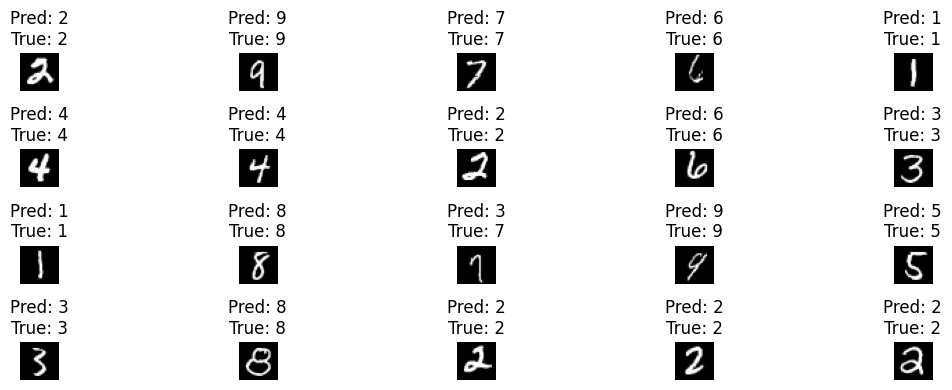

In [67]:
model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Plot 10 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze().cpu(), cmap='gray') # Added .cpu() here
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()